In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Function for full wave rectification
def full_wave_rectification(emg_data):
    return np.abs(emg_data)

# Function to design a Butterworth filter
def butter_filter(cutoff_freq, sampling_freq, btype, order=4):
    nyquist_freq = 0.5 * sampling_freq
    if isinstance(cutoff_freq, list) or isinstance(cutoff_freq, tuple):
        normal_cutoff = [freq / nyquist_freq for freq in cutoff_freq]
    else:
        normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

# Function to apply a Butterworth filter to EMG signals
def butter_filter_signal(emg_data, cutoff_freq, sampling_freq, btype='band', order=4):
    emg_data_filtered = np.zeros_like(emg_data)
    for ch in range(emg_data.shape[0]):
        b, a = butter_filter(cutoff_freq, sampling_freq, btype, order)
        emg_data_filtered[ch, :] = filtfilt(b, a, emg_data[ch, :])
    return emg_data_filtered

# Function for RMS smoothing
def rms_smoothing(emg_data, window_size):
    smoothed = np.zeros_like(emg_data)
    half_win = window_size // 2
    for ch in range(emg_data.shape[0]):
        for t in range(half_win, emg_data.shape[1] - half_win):
            window = emg_data[ch, t - half_win:t + half_win]
            smoothed[ch, t] = np.sqrt(np.mean(window ** 2))
    return smoothed

# Function to plot EMG signals
def plot_emg_data(emg_data, sampling_freq, title="EMG Signal", duration_sec=None):
    if duration_sec:
        n_samples = int(duration_sec * sampling_freq)
        emg_data = emg_data[:, :n_samples]
    
    time_axis = np.arange(emg_data.shape[1]) / sampling_freq
    plt.figure(figsize=(12, 8))
    for ch in range(min(8, emg_data.shape[0])):  # Plot up to 8 channels
        plt.plot(time_axis, emg_data[ch, :], label=f"Channel {ch+1}")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function to preprocess EMG
def preprocess_emg(X_raw, sampling_freq=1024):
    X_processed = np.zeros_like(X_raw)
    for session in range(X_raw.shape[0]):
        emg = X_raw[session]

        # Step 1: Full-wave rectification
        emg_rectified = full_wave_rectification(emg)

        # Step 2: Bandpass filter (e.g., 20-450 Hz typical for EMG)
        emg_filtered = butter_filter_signal(emg_rectified, [20, 450], sampling_freq, btype='band', order=4)

        # Step 3: RMS smoothing with a 100ms window
        window_size_samples = int(0.1 * sampling_freq)  # 100ms window
        emg_smoothed = rms_smoothing(emg_filtered, window_size_samples)

        X_processed[session] = emg_smoothed

    return X_processed

In [ ]:
# Example assuming X_train_raw already loaded
PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project'
X_train_raw = np.load(PATH + '/data/guided/guided_dataset_X.npy')

print(f"Original EMG shape: {X_train_raw.shape}")  # (5 sessions, 8 channels, 230000 samples)

# Preprocess EMG
X_train_processed = preprocess_emg(X_train_raw, sampling_freq=1024)

# Plot only first 4 seconds of session 1
plot_emg_data(X_train_processed[0], sampling_freq=1024, title="Preprocessed EMG - 4 seconds", duration_sec=50)

Original EMG shape: (5, 8, 230000)


TypeError: TransformerMixin.fit_transform() missing 1 required positional argument: 'X'

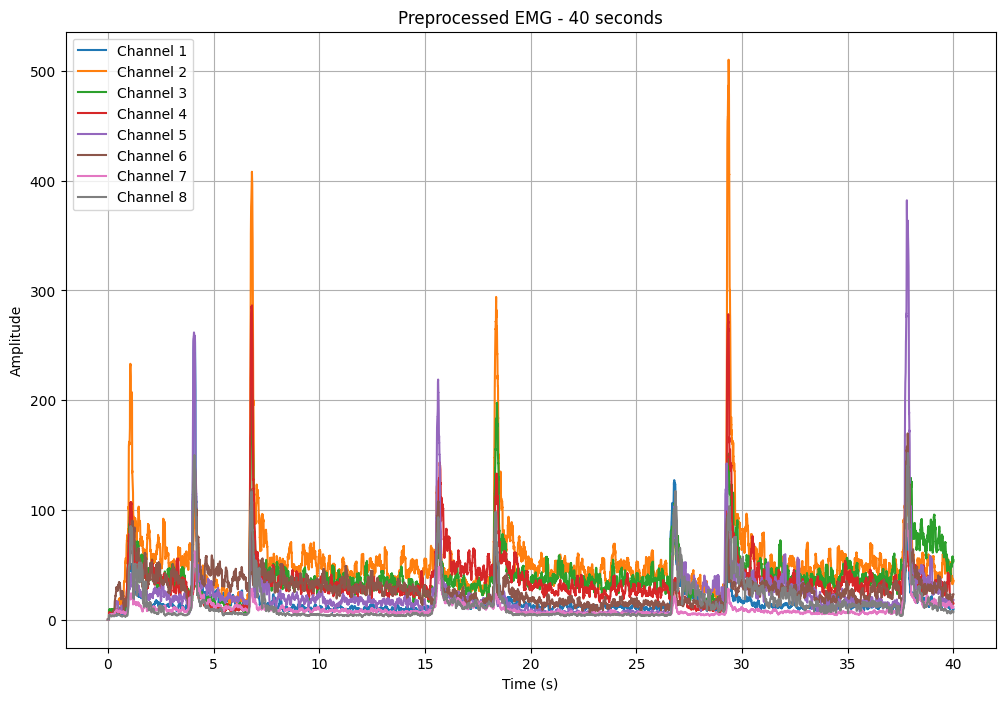

In [ ]:
# Plot only first 40 seconds of session 1
plot_emg_data(X_train_processed[0], sampling_freq=1024, title="Preprocessed EMG - 40 seconds", duration_sec=40)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import butter, filtfilt, iirnotch, resample, decimate, sosfiltfilt

class EmgFilterTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        original_fs=1024,
        target_fs=2048,
        f0=50.0,
        bw=5.0,
        low=30.0,
        high=500.0,
        order=4,
    ):
        self.original_fs = original_fs
        self.target_fs = target_fs
        self.f0 = f0
        self.bw = bw
        self.low = low
        self.high = high
        self.order = order

    def fit(self, X, y=None):
        # No fitting required
        return self

    def transform(self, X):
        # Apply filtering to each sample independently
        if X.ndim != 3:
            raise ValueError("Expected input of shape (samples, channels, time)")
        filtered = np.zeros_like(X)
        for i in range(X.shape[0]):
            for ch in range(X.shape[1]):
                filtered[i, ch] = self._filter_channel(X[i, ch])
        return filtered

    def _filter_channel(self, x):
        # 1. Upsample
        x_resampled = self._resample_signal(x, self.original_fs, self.target_fs)

        # 2. Notch filter
        Q = self.f0 / self.bw
        b_notch, a_notch = iirnotch(self.f0, Q, self.target_fs)
        x_notched = filtfilt(b_notch, a_notch, x_resampled)

        # 3. Bandpass filter
        sos = butter(self.order, [self.low, self.high], btype="bandpass", fs=self.target_fs, output="sos")
        x_filtered = sosfiltfilt(sos, x_notched)

        # 4. Downsample back
        return self._resample_signal(x_filtered, self.target_fs, self.original_fs)

    def _resample_signal(self, signal, original_fs, target_fs):
        ratio = original_fs / target_fs
        if ratio > 1:
            if not ratio.is_integer():
                raise ValueError("Use Method 2 for non-integer ratios")
            return decimate(signal, int(ratio), zero_phase=True)
        elif ratio < 1:
            num_samples = int(len(signal) * target_fs / original_fs)
            return resample(signal, num_samples)
        return signal

# Example assuming X_train_raw already loaded
PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project'
X_train_raw = np.load(PATH + '/data/guided/guided_dataset_X.npy')

print(f"Original EMG shape: {X_train_raw.shape}")  # (5 sessions, 8 channels, 230000 samples)

# Preprocess EMG
X_train_processed = EmgFilterTransformer().fit_transform(X_train_raw)

print(f"Filtered EMG shape: {X_train_processed.shape}")

Original EMG shape: (5, 8, 230000)
Filtered EMG shape: (5, 8, 230000)


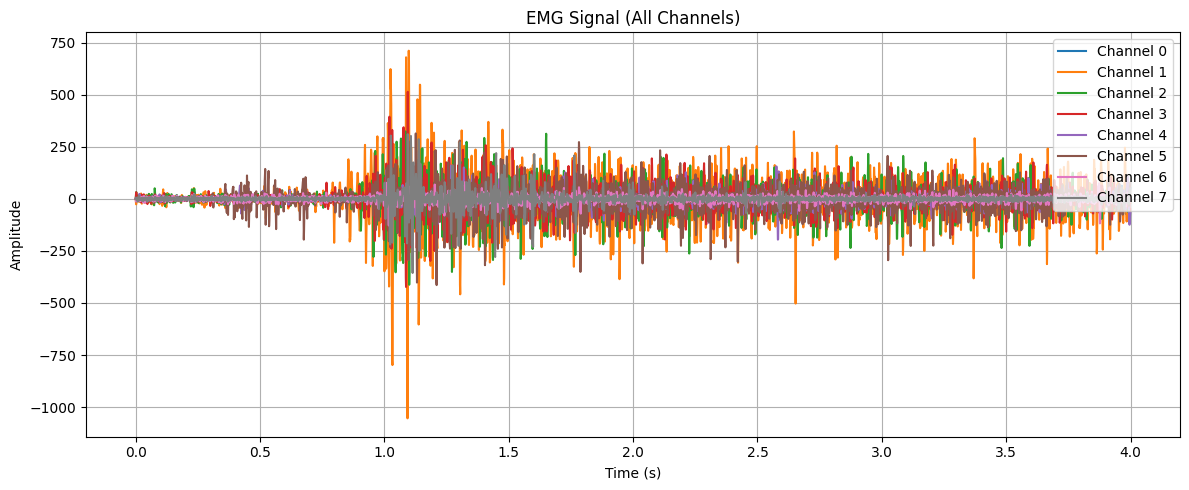

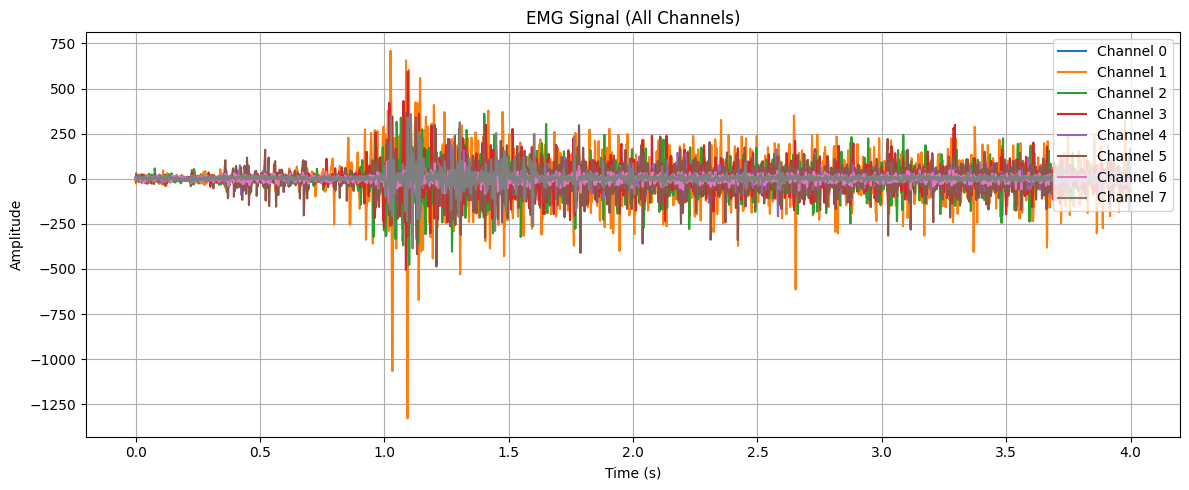

In [8]:
def plot_emg_all_channels(signal, fs=1024, duration_sec=4, title="EMG Signal (All Channels)"):
    """
    Plots all EMG channels in a single graph for the specified duration.

    Args:
        signal (np.ndarray): shape (channels, time)
        fs (int): sampling frequency in Hz
        duration_sec (float): duration to plot in seconds
        title (str): title of the plot
    """
    n_channels, n_samples = signal.shape
    max_samples = int(fs * duration_sec)
    t = np.arange(max_samples) / fs

    plt.figure(figsize=(12, 5))
    for i in range(n_channels):
        plt.plot(t, signal[i, :max_samples], label=f'Channel {i}')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_emg_all_channels(X_train_processed[0], fs=1024, duration_sec=4)
plot_emg_all_channels(X_train_raw[0], fs=1024, duration_sec=4)

In [11]:
class EMGPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_freq=1024, bandpass_range=(20, 450), order=4, rms_window_ms=100):
        self.sampling_freq = sampling_freq
        self.bandpass_range = bandpass_range
        self.order = order
        self.rms_window_samples = int(rms_window_ms * sampling_freq / 1000)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_processed = np.zeros_like(X)
        for session in range(X.shape[0]):
            emg = X[session]
            emg_rectified = self._full_wave_rectification(emg)
            emg_filtered = self._butter_filter_signal(emg_rectified)
            emg_smoothed = self._rms_smoothing(emg_filtered)
            X_processed[session] = emg_smoothed
        return X_processed

    def _full_wave_rectification(self, emg_data):
        return np.abs(emg_data)

    def _butter_filter(self, cutoff_freq, btype):
        nyquist_freq = 0.5 * self.sampling_freq
        if isinstance(cutoff_freq, (list, tuple)):
            normal_cutoff = [f / nyquist_freq for f in cutoff_freq]
        else:
            normal_cutoff = cutoff_freq / nyquist_freq
        b, a = butter(self.order, normal_cutoff, btype=btype, analog=False)
        return b, a

    def _butter_filter_signal(self, emg_data):
        emg_data_filtered = np.zeros_like(emg_data)
        for ch in range(emg_data.shape[0]):
            b, a = self._butter_filter(self.bandpass_range, btype='band')
            emg_data_filtered[ch, :] = filtfilt(b, a, emg_data[ch, :])
        return emg_data_filtered

    def _rms_smoothing(self, emg_data):
        smoothed = np.zeros_like(emg_data)
        half_win = self.rms_window_samples // 2
        for ch in range(emg_data.shape[0]):
            for t in range(half_win, emg_data.shape[1] - half_win):
                window = emg_data[ch, t - half_win:t + half_win]
                smoothed[ch, t] = np.sqrt(np.mean(window ** 2))
        return smoothed


# Preprocess EMG
X_train_processed = EMGPreprocessor().fit_transform(X_train_raw)

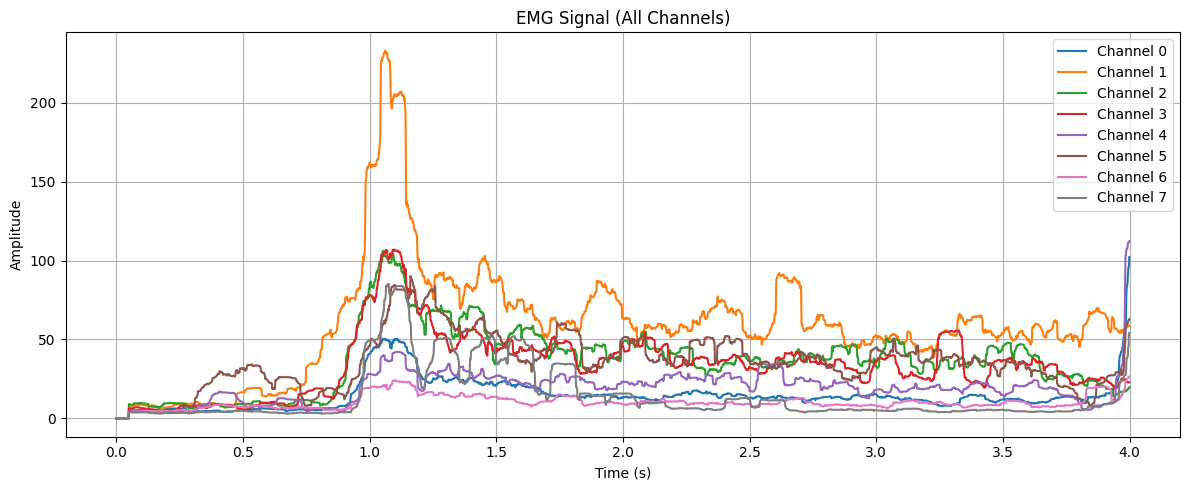

In [12]:
plot_emg_all_channels(X_train_processed[0], fs=1024, duration_sec=4)